In [52]:
"""Some plots of the covid-19 data.

Setup:
* Check out the hopkins covid cases data: 

    git clone https://github.com/CSSEGISandData/COVID-19.git

* Download state populations:

    curl https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv > state_populations.csv
    
* Download global populations:

    curl https://datahub.io/JohnSnowLabs/population-figures-by-country/r/population-figures-by-country-csv.csv > country_populations.csv

* If you want to export images, install orca, which will run as a background server the first time you export:

    npm install -g electron@1.8.4 orca
     
* Install the requirements, in a virtualenv obviously. (Currently lazy `pip freeze`):

    pip install -r requiements.txt
     
"""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn as sns
import datetime as dt
import os

# ## Wide
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# DATA OPTIONS
START_DAY = dt.datetime(year=2020, month=2, day=28)
END_DAY = dt.datetime.utcnow() + dt.timedelta(days=1)

# EXPORT
# Export requires orca, see https://plot.ly/python/static-image-export/
EXPORT = True

pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 40)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [53]:
## LOAD THE DATA
# ... and clean it up

# Read data from https://github.com/CSSEGISandData/COVID-19/
def load_and_normalize(path, value):

    df = pd.read_csv(path, infer_datetime_format=True,)
    df = df.rename(
        columns={
            "Province/State": "state",
            "Country/Region": "country",
            "Lat": "lat",
            "Long": "lon",
            "Cases": "cases",
            "Date": "date",
            "Deaths": "deaths",
        }
    )

    # Normalize
    df = pd.melt(
        df,
        id_vars=list(df.columns[:4]),  # All columns before date columns
        value_vars=list(df.columns[4:]),
        var_name="date",
        value_name=value,
    )
    df["date"] = pd.to_datetime(df["date"])

    # Index by date
    df = df.set_index("date")
    
    df = df.drop("lat", axis=1)
    df = df.drop("lon", axis=1)
    
    # Filter date ranges we care about
    df["day"] = (df.index - START_DAY).days
    df = df[df["day"] > 0].copy()
    
    return df


cases_confirmed_df = load_and_normalize(
    "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv",
    value="cases",
)
deaths_df = load_and_normalize(
    "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv",
    value="deaths",
)

joined_df = cases_confirmed_df.merge(deaths_df, on=["date", "day", "state", "country"])


####### US DATA
us = joined_df[joined_df["country"] == "US"].copy()

# Load state populations
# source: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/
popsdf = pd.read_csv("state_populations.csv")
# next(popsdsf)
pops = {p["NAME"]: int(p["POPESTIMATE2019"]) for _, p in list(popsdf.iterrows())}


# Data until ~03-10 is split by county, which is hella annoying
# First, add the county totals to the state totals
states = json.load(open("states.json"))
for abbrev, state in states.items():
    us.loc[us["state"].str.contains(abbrev), ["state"]] = state

# Remove any lingering county labels
us = us[~us["state"].str.contains(",")]
# Remove princesses
us = us[~us["state"].str.contains("incess")]
# Groupy by state
us = us.groupby(["date", "day", "state", "country"]).sum()
us = us.reset_index().set_index("day")

us["cases_per_100k"] = us.apply(
    lambda c: float(c.cases) * 100000 / pops.get(c.state, 100000000), axis=1
)


####### GLOBAL DATA
# source: https://datahub.io/JohnSnowLabs/population-figures-by-country
globpops_df = pd.read_csv("country_populations.csv")
globpops = {p["Country"]: int(p["Year_2010"]) for _, p in list(globpops_df.iterrows())}
## Fix some important ones
hopkins_name_from_popcsv = {
    "Iran": "Iran, Islamic Rep.",
    "Korea, South": "Korea, Rep.",
    "US": "United States",
}
for hopkins_name, csv_name in hopkins_name_from_popcsv.items():
    globpops[hopkins_name] = globpops[csv_name]

glob = joined_df.copy()

glob = glob.groupby(["date", "day", "country"]).sum()
glob = glob.reset_index().set_index("day")
glob["cases_per_100k"] = glob.apply(
    lambda c: float(c.cases) * 100000 / globpops.get(c.country, 100000000), axis=1
)

In [54]:
### Compute number of new cases per day
def new_cases_per_day(df, key="state", val="cases"):
    """Compute a new_cases column, add it to the df, and return the result."""
    df = df.copy()
    df.sort_values([key, "date"], inplace=True)

    # for this example, with diff, I think this syntax is a bit clunky
    # but for more general examples, this should be good.  But can we do better?
    df["new_cases"] = df.groupby([key])["cases"].transform(lambda x: x.diff())

    df.sort_index(inplace=True)
    return df

def find_scary(df, groupby, metric, n=10):
    return list(df.groupby([groupby])[metric].max().sort_values()[-10:].copy().index)

def filter_scary(df, groupby, metric, n=10):
    scary = find_scary(df, groupby, metric, n)
    return df[df[groupby].isin(scary)].copy()

### Find the scary states we want to plot
# scary_state_counts = us.groupby(["state"])["cases_per_100k"].max()
# scary_states = list(scary_state_counts[scary_state_counts > 1.0].copy().index)
# scary_states = [c for c in scary_states if pops[c] > 6000000]
# scary_cases = us[us["state"].isin(scary_states)].copy()

scary_cases = filter_scary(us, "state", "cases")
scary_cases = new_cases_per_day(scary_cases)


### Find the scary countries we want to plot
# scary_country_counts = glob.groupby(["country"])["cases_per_100k"].max()
# scary_countries = list(scary_country_counts[scary_country_counts > 1.5].copy().index)
# # Filter out smaller countries
# scary_countries = [c for c in scary_countries if globpops[c] > 20000000]

scary_country_cases = filter_scary(glob, "country", "cases")
scary_country_cases = new_cases_per_day(scary_country_cases, key="country")

In [58]:
## Try plotly?
import plotly.graph_objects as go
import plotly.express as px


def covidly(df, y="cases_per_100k", color="state", **kwargs):
    fig = px.line(df.reset_index(), x="date", y=y, color=color, **kwargs)
    return fig


def covidly_overlay(df, y="cases", color="state", **kwargs):
    line_fig = px.line(df.reset_index(), x="date", y=y, color=color, **kwargs)
    # Overlay bars. NOTE: this doesn't work well with more than ~5 plots
    bars_fig = px.bar(
        df.reset_index(), x="date", y="new_cases", color=color, height=800, **kwargs
    )
    for bar in bars_fig.data:
        line_fig.add_trace(bar)
    return line_fig


def covidly_bars(df, y="new_cases", color="state", **kwargs):
    bars_fig = px.bar(df.reset_index(), x="date", y=y, color=color, **kwargs)
    return bars_fig

In [59]:
#### Plot deaths
covidly(scary_country_cases, y="deaths", color="country").show()
covidly(scary_cases, y="deaths").show()

In [60]:

if EXPORT and not os.path.exists("plots"):
    os.mkdir("plots")

pretty_date = dt.datetime.utcnow().strftime("%Y-%m-%d")

state_cases = covidly(scary_cases, y="cases_per_100k", log_y=True)
if EXPORT:
    state_cases.write_image(f"plots/{pretty_date}-us_cases_per_100k_lines.png")
state_cases.show()

state_cases_lbars = covidly_overlay(scary_cases, y="cases", log_y=True)
if EXPORT:
    state_cases_lbars.write_image(f"plots/{pretty_date}-us_cases_lines_bars.png")
state_cases_lbars.show()


# state_cases_bars = covidly_bars(scary_cases, height=300)
# if EXPORT:
#     state_cases_bars.write_image(f"plots/{pretty_date}-us_cases_bars.png")
# state_cases_bars.show()


world = covidly(scary_country_cases, y="cases", color="country", log_y=True)
if EXPORT:
    world.write_image(f"plots/{pretty_date}-world_cases_lines.png")
world.show()

world_per = covidly(
    scary_country_cases, y="cases_per_100k", color="country", log_y=True
)
if EXPORT:
    world_per.write_image(f"plots/{pretty_date}-world_cases_per_100k_lines.png")
world_per.show()

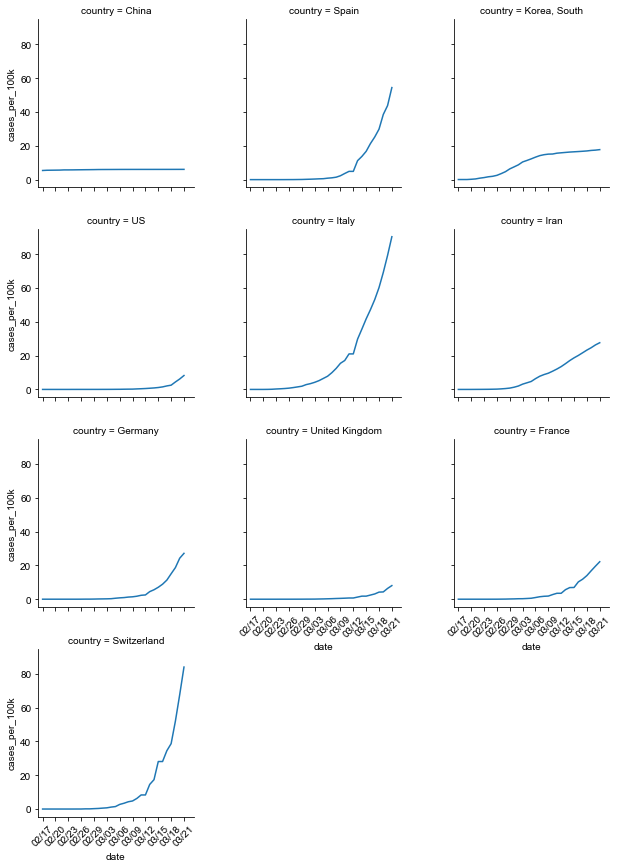

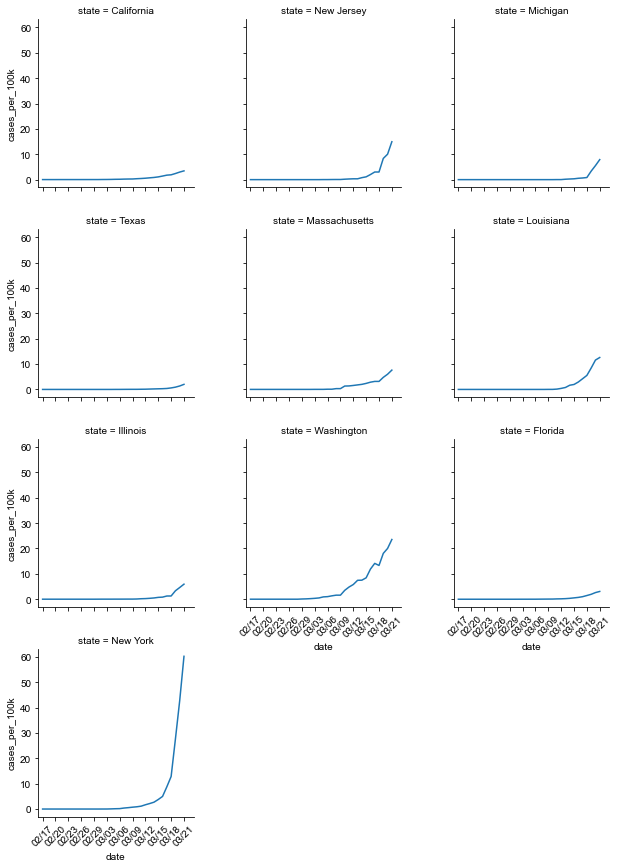

In [50]:
#### v1 plots, with seaborn.

import matplotlib.dates as mdates

date_fmt = mdates.DateFormatter("%m/%d")


def plovid(data, split="state"):
    sns.reset_orig()
    ax = sns.relplot(
        data=data.reset_index(),
        x="date",
        y="cases_per_100k",
        col=split,
        col_wrap=3,
        kind="line",
        ci=None,
        height=3,
    )
    ax.set(xlim=(START_DAY, END_DAY))
    xticks = np.array(data["date"].unique())[::3]
    ax.set(xticks=xticks)
    xlabels = [pd.to_datetime(str(i)).strftime("%m/%d") for i in xticks]
    ax.set_xticklabels(labels=xlabels, rotation=45)
    sns.set_style("ticks", {"xtick.major.formatter": date_fmt})
    return ax


ax = plovid(scary_country_cases, split="country")
ax.savefig("countries.png")
ax = plovid(scary_cases)
ax.savefig("us.png")